In [1]:
import os
import pandas as pd
import io
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress Tensorflow logging (1)
import tensorflow as tf
import os
CUSTOM_MODEL_NAME = 'my_ssd_mobnet'
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME),
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'),
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'),
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'),
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME),
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}
for path in paths.values():
    if not os.path.exists(path):
      !mkdir -p {path}

if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}
#installing the tensorflow object detection model in our current working environment
#this step can take a couple of tries as it requires a lot of troubleshooting
#since, we are running colab, it uses a linux operating system
!pip install -q opendatasets
!apt-get install protobuf-compiler
!cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install .

VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
!python {VERIFICATION_SCRIPT}

#to download the pre-trained model and move it to the pretrained model folder
!wget {PRETRAINED_MODEL_URL}
!mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
!cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}
#Now we can start training the Tensorflow Object Detection Model
#For that, we need to create the labels. Here, we only have single label - Licence. This is also the name of the annotation
#in the xml files for each image
#The label map is the list of all possible objects that the model can detect.
#for example, if I wanted to detect cars, bikes, and humans, the label map would contain 3 objects
#Since, for our problem, we only want to detect a single object, the label map only contains a single object
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME),
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}
labels = [{'name':'licence', 'id':1}]
with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

!cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format
config = config_util.get_configs_from_pipeline_file(files["PIPELINE_CONFIG"])
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:
    proto_str = f.read()
    text_format.Merge(proto_str, pipeline_config)
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]
config_text = text_format.MessageToString(pipeline_config)
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:
    f.write(config_text)

#to automatically delete the cell output
from IPython.display import clear_output
clear_output()

In [2]:
!pip3 install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -q light-the-torch >> /.tmp
!ltt install torch torchvision >> /.tmp
!pip install -q fastai --upgrade >> /.tmp
!pip install -q easyocr

#to automatically delete the cell output as it is not important
from IPython.display import clear_output
clear_output()

This is the important part. **Do not run the next cell without completing the instructions written here**
# **Copy the pre-trained weights to the directory so that they can be loaded into the model**
Upload three files to this local session's storage -
1. checkpoint
2. chkpt-6.index
3. chkpt-6.data-00000-of-00001

Now copy these files to the following directory -
'/content/Tensorflow/workspace/models/my_ssd_mobnet'

Finally, it should look something like this -



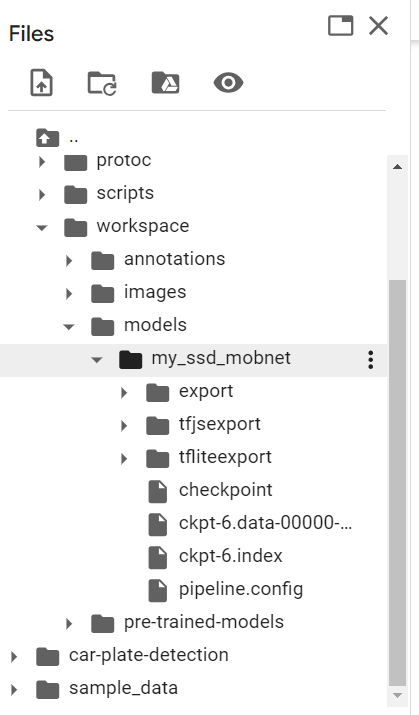

In [3]:
#After doing this, we need to copy the file containing the weights of the neural network to the directory specified below
#I have also attached a screenshot below of how the directory should look like after copying the weights

In [4]:
import os
import tensorflow as tf
import object_detection
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util
import numpy as np

#Now, the problem is that EasyOCR requires us to use PyTorch. So, we need to limit GPU usage by tensorflow so that we have some memory left to run pytorch
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 8196)])
  except RuntimeError as e:
    print(e)

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-6')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

detection_threshold = 0.5
region_threshold = 0.1
import easyocr

def ocr_filtering(region, ocr_result, region_threshold):
  image_area = region.shape[0]*region.shape[1]
  plate = []

  for result in ocr_result:
    length = np.sum(np.subtract(result[0][1], result[0][0]))
    width = np.sum(np.subtract(result[0][2], result[0][1]))
    if length*width > region_threshold*image_area:
      plate.append(result[1])
  return plate

import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])


def optical_character_recognition(image, detections, detection_threshold, region_threshold):
  #looping through the scores of the various detections and only accepting the values that surpass a particular threshold (0.7 here)
  scores = list(filter(lambda x: x > detection_threshold, detections['detection_scores']))
  boxes = detections["detection_boxes"][0:len(scores)]
  classes = detections['detection_classes'][0:len(scores)]

  #dimensions of the image that has been given as input
  width = image.shape[1]
  height = image.shape[0]

  for idx, box in enumerate(boxes):
    plate_reg = box*[height, width, height, width]
    region = image[int(plate_reg[0]):int(plate_reg[2]), int(plate_reg[1]): int(plate_reg[3])]
    reader = easyocr.Reader(['en'])
    ocr_result = reader.readtext(region)
    text = ocr_filtering(region, ocr_result, region_threshold)
    return text

# **WITHOUT GRADIO**

In [5]:
#if the gradio code does not work
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


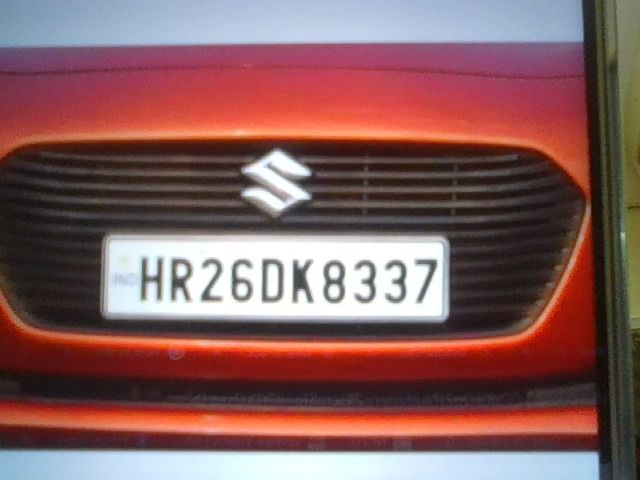

In [6]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete['HRZSDK8337']


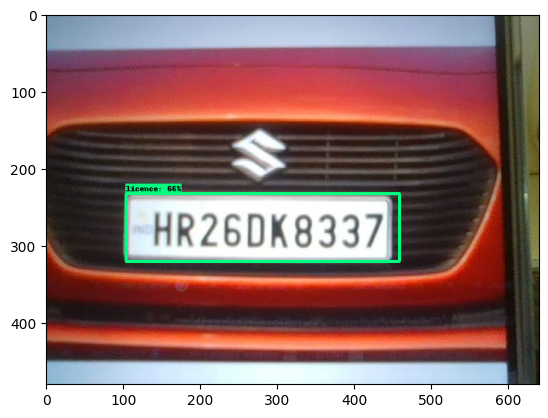

In [7]:
img = cv2.imread('/content/photo.jpg')
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.5,
            agnostic_mode=False)
try:
  text = optical_character_recognition(image_np_with_detections, detections, detection_threshold, region_threshold)
  print(text)
except:
  pass
plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
print(text)
#this because easyocr is easy to use and integrate, it is not as accurate as other OCR engines like Tesseract OCR etc.

['HRZSDK8337']


# **WITH GRADIO**

In [9]:
!pip install gradio
import gradio as gr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.7/302.7 kB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.9/381.9 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 10.0 MB/s

ImportError: ignored

In [35]:
#to automatically delete the cell output as it is not important
from IPython.display import clear_output
clear_output()
from PIL import Image
import tempfile
def recognize_license_plate(image):
    # Process the image to the format your model expects
    # This might involve resizing, normalization, etc.
    # Example: processed_image = preprocess_image(image)

    # Predict using your TFOD model
    # prediction = model.predict(processed_image)

    # For now, just returning a placeholder text
    pil_image = Image.fromarray(np.uint8(image)).convert('RGB')
    # Create a temporary file to save the image
    temp_file = tempfile.NamedTemporaryFile(delete=False, suffix='.jpg')
    pil_image.save(temp_file.name)
    img = cv2.imread(pil_image.name)

    image_np = np.array(img)
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    return ("HELLO", input_tensor.shape, image_np.shape)
    detections = detect_fn(input_tensor)
    return "HELLO"
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
    detections['num_detections'] = num_detections
    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
    label_id_offset = 1
    image_np_with_detections = image_np.copy()
    viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.5,
            agnostic_mode=False)
    try:
      text = optical_character_recognition(image_np_with_detections, detections, detection_threshold, region_threshold)
      print(text)
    except:
      pass
    return text

iface = gr.Interface(
    fn=recognize_license_plate,  # the function to wrap
    inputs=gr.Image(sources="webcam", mirror_webcam = False, label = "image"),  # set source to 'webcam' for webcam input
    outputs="text",  # the model returns text; change as needed
    title="License Plate Recognition",
    description="Capture an image using your webcam to detect the license plate."
)

# Launch the interface
iface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://0844c18a22365bc4e5.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
